# CrossSim: a hardware/software co-design tool for analog in-memory computing

### Tutorial for CrossSim v3.0

www.cross-sim.sandia.gov/ <br>
www.github.com/sandialabs/cross-sim

## Outline

- Part 0: What is CrossSim?
- Part 1: The AnalogCore interface
- Part 2: Physical models and data mapping options
- Part 3: Custom device models

## Part 0: What is CrossSim?

CrossSim is a modeling framework that is built mainly around a key analog computational primitive: matrix-vector multiplication (MVM) in a crossbar memory array. We'll primarily talk about a resistive crossbar array but the framework is general enough to encompass other in-memory computing systems (e.g. SRAM, DRAM). Crossbars can also implement outer product update, but we won't cover that in this tutorial.

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/mvm.png" width="550" />

Analog MVM can potentially be very energy-efficient, fast, and compact, and this has made it an attractive recent area of research. But being analog rather than digital, these systems are also more susceptible to errors unless carefully designed. There are all sorts of errors that can creep in during the computation of an analog MVM. Listed below are just a few.


<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/mvm_nonideal.png" width="650" />


CrossSim is a tool that provides detailed models to propgate device- and circuit-level errors to the algorithm. It also serves as a multi-scale design space exploration tool from devices and circuits, architectures, and algorithms to ensure accuracy and reliability. CrossSim offers a unique combination of application versatility, modeling fidelity, modeling flexibility, and speed that make it well suited for hardware/software co-design. We'll show off some of this in this tutorial.

In [1]:
%matplotlib inline
import sys
sys.path.append("..")
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(198)

# CrossSim modules
from simulator import AnalogCore
from applications.mvm_params import set_params

## Part 1: The AnalogCore interface

New in CrossSim 3.0 is an easy-to-use and highly flexible interface to simulate analog MVMs. To run this simulation, we create an object called an AnalogCore. As we'll show, the AnalogCore can then be dropped into arbitrary Python application code. The picture below shows the internal organization of an AnalogCore. On the left are the inputs to the core.

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/AnalogCore_overview.png" width="650" />

### 1.1. AnalogCore API basics

#### 1.1.1. MVM

We'll start by using CrossSim's MVM functionality. As the simplest example, we'll start by multiplying a random matrix with a random vector.

In [2]:
# Define a random matrix W
N1, N2 = 300, 200
W = np.random.uniform(-1,1,size=(N2,N1))

# Define a random vector x
x = np.random.uniform(-1,1,size=(N1,))

# Compute the MVM in NumPy:
y_np = W @ x

Now let's compute the same thing using CrossSim's AnalogCore. We first set the hardware parameters of the analog IMC core we want to simulate. For now, we create a core that assumes ideal devices and circuits with infinite precision. This is the default case if no parameters are explicitly specified:

In [3]:
# Use default parameters
params = set_params()

# Create an AnalogCore, pass in the params, and program matrix
xbar = AnalogCore(W, params=params)

# Use the AnalogCore like a NumPy array
y_xsim = xbar @ x

Once created, the AnalogCore can be treated as if it were the familiar NumPy array, except that when multiplying by the AnalogCore, an analog MVM is being simulated!

Now let's compare CrossSim's MVM result with NumPy and plot the result. Since we assumed ideal analog hardware, they should match exactly.

In [4]:
assert(np.allclose(y_np,y_xsim))
print("--- MVM check passed! ---")

--- MVM check passed! ---


#### 1.1.2. VMM

Below are a sevreal more examples that show off the versatility of AnalogCore, and how it behaves in much the same way as a NumPy array.

We can multiply by the transpose of the array (resize input vector accordingly):

In [5]:
## Multiply by the transpose of the array
x = np.random.uniform(-1,1,size=(N2,))
y_np = W.T @ x
y_xsim = xbar.T @ x

assert(np.allclose(y_np,y_xsim))
print("--- Transpose MVM check passed! ---")

--- Transpose MVM check passed! ---


A more physically proper way to do this is to take the same AnalogCore and multiply it with an input from a different direction (e.g. input applied to columns rather than rows). This is done simply by putting the vector on the left and the AnalogCore on the right. We call this a vector-matrix multiplication (VMM), which is the transpose operation of the MVM:

In [6]:
y_np = x @ W
y_xsim = x @ xbar

assert(np.allclose(y_np,y_xsim))
print("--- VMM check passed! ---")

--- VMM check passed! ---


#### 1.1.3: Computing with sub-arrays

We can also use a portion of the crossbar array rather than the full array. Here is an example:

In [7]:
x = np.random.uniform(-1,1,20)
y_np = W[:20, :20] @ x
y_xsim = xbar[:20, :20] @ x

assert(np.allclose(y_np,y_xsim))
print("--- Subarray check #1 passed! ---")

--- Subarray check #1 passed! ---


Another example where we apply the elements of the input vector to every other row of the array:

In [8]:
x = np.random.uniform(-1,1,size = (N1//2,))
y_np = W[::2, ::2] @ x
y_xsim = xbar[::2, ::2] @ x

assert(np.allclose(y_np,y_xsim))
print("--- Subarray check #2 passed! ---")

--- Subarray check #2 passed! ---


#### 1.1.4: Matrix-matrix multiplication

A matrix-matrix multiplication, or MatMul, can be decomposed into a series of MVMs with a fixed matrix. The user doesn't need to perform this decomposition: we can simply multiply the AnalogCore with a NumPy matrix and the decomposition will be handled internally. Depending on the core parameters, simulating MatMuls in this way can give a large speedup over simulating individual MVMs.

Let's multiply two random matrices together. In this case we designate one matrix $\mathbf{W}$ to be programmed into the array conductances: this could implement the weights of a filter or a neural network layer. The other matrix $\mathbf{X}$ is a matrix of input values that will be decomposed into input vectors in the physical system.

In [9]:
# Generate a matrix to be programmed into the array
W = np.random.uniform(-1,1,size=(N2,N1))

# Generate a matrix of input values with the appropriate dimensions
X = np.random.uniform(-1,1,size=(N1,N1))

# Compute the MatMul in NumPy
Y_np = W @ X

# Create and program an AnalogCore
xbar = AnalogCore(W, params=params)

# Compute the MatMul in CrossSim
Y_xsim = xbar @ X

# We relax the check slightly for this test
assert(np.allclose(Y_np,Y_xsim,atol=1e-6))
print("--- Left MatMul check passed! ---")

--- Left MatMul check passed! ---


We can also reverse the order of the matrix multiplication. In this case, CrossSim will simulate a sequence of VMMs rather than MVMs.

In [10]:
# Generate a matrix of input values with the appropriate dimensions
X = np.random.uniform(-1,1,size=(N2,N2))

# Compute the MatMul in NumPy
Y_np_2 = X @ W

# Compute the MatMul in CrossSim
Y_xsim_2 = X @ xbar

# We relax the check slightly for this test
assert(np.allclose(Y_np_2,Y_xsim_2,atol=1e-6))
print("--- Right MatMul check passed! ---")

--- Right MatMul check passed! ---


#### 1.1.5. Re-programming a core

Now let's suppose that we would like to program a new matrix into the array. Rather than creating a new AnalogCore, we can re-program the same one. There are two ways to do this. The first is the set_matrix() method in AnalogCore:

In [11]:
# Create a new random matrix with the same dimensions and compute the NumPy MVM
W_new = np.random.uniform(-1,1,size=(N2,N1))
x = np.random.uniform(-1,1,size=(N1,))
y_np_new = W_new @ x

# Re-program the core, according to the original params
xbar.set_matrix(W_new)

# Run an MVM and check the result
y_xsim_new = xbar @ x

assert(np.allclose(y_np_new,y_xsim_new,atol=1e-6))
print("--- Core re-programming check #1 passed! ---")

--- Core re-programming check #1 passed! ---


We can also put the matrix to be programmed on the right side of an assignment. By including the [:] syntax, this will implicitly call set_matrix:

In [12]:
# Create another new random matrix with the same dimensions and compute the NumPy MVM
W_new2 = np.random.uniform(-1,1,size=(N2,N1))
y_np_new2 = W_new2 @ x

# Re-program the core again
xbar[:] = W_new2

# Run an MVM and check the result
y_xsim_new2 = xbar @ x

assert(np.allclose(y_np_new2,y_xsim_new2,atol=1e-6))
print("--- Core re-programming check #2 passed! ---")

--- Core re-programming check #2 passed! ---


Finally, we can use this syntax to partially re-program the memory array (and apply the associated programming errors, if enabled). The rest of the array will be left intact.

In [13]:
# Let's take the W_new2 matrix and change a 50x75 block of elements
W_new_block = np.random.uniform(-1,1,size=(50,75))
W_new2[50:100,75:150] = W_new_block

# Re-program a portion of the core
xbar[50:100,75:150] = W_new_block

# Run MVMs and check the result
y_np_new3 = W_new2 @ x
y_xsim_new3 = xbar @ x

assert(np.allclose(y_np_new3,y_xsim_new3,atol=1e-6))
print("--- Subarray re-programming check passed! ---")

--- Subarray re-programming check passed! ---


### 1.2. Example: Discrete Fourier Transform

Now let's move onto a more interesting example than multiplying random matrices and vectors.

We can also perform math on complex numbers, not just real ones. Consider the Discrete Fourier Transform (DFT). The 1D DFT is usually computed using the Fast Fourier Transform (FFT) algorithm. Let's first compute the DFT using Numpy's FFT. We'll apply it to two classic examples: a rectangular pulse input and a sinc input. First, we create these 1D input waveforms with length 256.

In [14]:
N_ft1 = 256

# Create a narrow rectangular pulse input
x1 = np.zeros(N_ft1, dtype=np.complex128)
x1[122:133] = 1

# Create a sinc waveform
inds = np.arange(N_ft1)
x2 = 32*(inds-N_ft1/2)/N_ft1
x2 = np.sinc(x2)

# Compute the FFT
y_np1 = np.fft.fftn(x1)
y_np2 = np.fft.fftn(x2)

The DFT can also be cast as an MVM:

$y_k = \sum \limits_{n=0}^{N-1} x_n \exp{\left(-i\frac{2\pi}{N}kn\right)} \implies \mathbf{y} = W\mathbf{x} $

where $x$, $y$, and $W$ can all be complex-valued. 

Under the hood, CrossSim implements  complex-valued matrix elements by decomposing the complex numbers into real, positive numbers since conductances in memory arrays are strictly positive. The code simulates DFTs being processed using analog MVMs.

In [15]:
# Create the DFT matrix, W
W = scipy.linalg.dft(N_ft1)

# Set parameters for an ideal complex-valued core
params = set_params(complex_matrix = True)

# Create an AnalogCore, pass in params, and program matrix
xbar = AnalogCore(W, params=params)

# Use the AnalogCore like a NumPy array
y_xbar1 = xbar @ x1
y_xbar2 = xbar @ x2

Let's plot the results for a visual comparison:

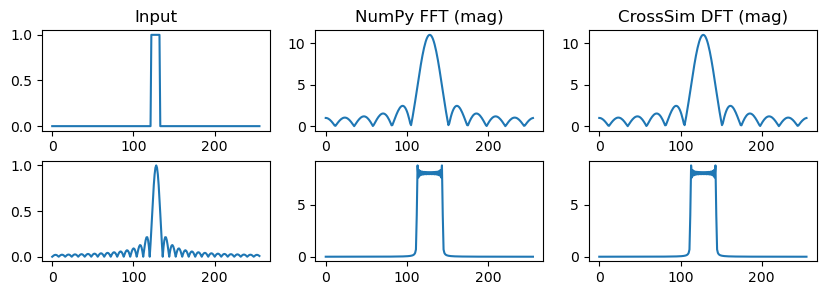

In [16]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,3))
plt.subplots_adjust(hspace=0.3)
ax1.plot(np.abs(x1))
ax2.plot(np.fft.fftshift(np.abs(y_np1)))
ax3.plot(np.fft.fftshift(np.abs(y_xbar1)))
ax4.plot(np.abs(x2))
ax5.plot(np.fft.fftshift(np.abs(y_np2)))
ax6.plot(np.fft.fftshift(np.abs(y_xbar2)))
ax1.set_title("Input")
ax2.set_title("NumPy FFT (mag)")
ax3.set_title("CrossSim DFT (mag)")
plt.show()

For the next example, let's look at how CrossSim's MVM can be used inside a larger block of code. Let's extend the DFT to two dimensions:

$Y_{j,k} = \sum \limits_{m=0}^{N-1} \sum \limits_{n=0}^{N-1} Y_{m,n} \exp{\left(-i\frac{2\pi}{N}kn\right)} \exp{\left(-i\frac{2\pi}{N}jm\right)}$

This can be written as:
$\mathbf{Y} = \mathbf{W}\mathbf{X}\mathbf{W}^T$

where $\mathbf{W}$ is the DFT matrix as above, and $\mathbf{X}$ and $\mathbf{Y}$ are the 2D input and output. This can be written as MVMs wrapped inside two successive loops.

Let's use a 256$\times$256 RGB image for this test.

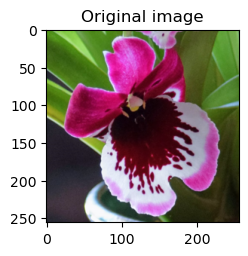

In [17]:
# Load image
N_ft1, N_ft2, Nch = 256, 256, 3
X_flower = Image.open('../applications/dsp/example_images/orchid.jpg').resize((N_ft1,N_ft2))
X_flower = np.array(X_flower).astype(np.float32) / 255

# Show image
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.imshow(X_flower)
ax.set_title("Original image")
plt.show()

Here is the block of code that takes the 2D DFT of this image, then takes the 2D inverse DFT of this image. First, let's write it using NumPy MVMs:

In [18]:
Y = np.zeros(X_flower.shape, dtype=np.complex128)
X_recon = np.zeros(X_flower.shape, dtype=np.complex128)

# DFT-256 matrix
W_dft = scipy.linalg.dft(N_ft1)
W_idft = np.matrix.getH(W_dft)

# Forward 2D DFT
for ch in range(Nch):
    y_imed = np.zeros((X_flower.shape[1],X_flower.shape[0]),dtype=np.complex128)
    for k in range(N_ft2):
        y_imed[k,:] = W_dft @ X_flower[:,k,ch]
    for k in range(N_ft1):
        Y[k,:,ch] = W_dft @ y_imed[:,k]
        
# Inverse 2D DFT
for ch in range(Nch):
    x_imed = np.zeros((Y.shape[1],Y.shape[0]),dtype=np.complex128)
    for k in range(N_ft1):
        x_imed[k,:] = W_idft @ Y[:,k,ch]
    for k in range(N_ft2):
        X_recon[k,:,ch] = W_idft @ x_imed[:,k]

# Normalize
X_recon = np.real(X_recon / N_ft1*N_ft2).clip(0,1)

To get the CrossSim version, we create two AnalogCores and simply replace "W" with "xbar" in the DFT loops.

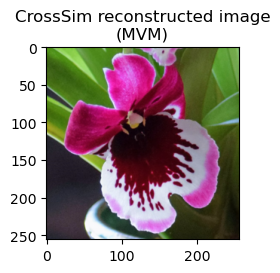

In [19]:
# Create and program DFT AnalogCore
params_dft = set_params(complex_matrix = True, complex_input = True)
xbar_dft = AnalogCore(W_dft, params=params_dft)

# Create IDFT AnalogCore
params_idft = set_params(complex_matrix = True, complex_input = True)
xbar_idft = AnalogCore(W_idft, params=params_idft)

Y = np.zeros(X_flower.shape,dtype=np.complex128)
X_recon = np.zeros(X_flower.shape, dtype=np.complex128)

# Forward 2D DFT
for ch in range(Nch):
    y_imed = np.zeros((X_flower.shape[1],X_flower.shape[0]),dtype=np.complex128)
    for k in range(N_ft2):
        y_imed[k,:] = xbar_dft @ X_flower[:,k,ch]
    for k in range(N_ft1):
        Y[k,:,ch] = xbar_dft @ y_imed[:,k]
        
# Inverse 2D DFT
for ch in range(Nch):
    x_imed = np.zeros((Y.shape[1],Y.shape[0]),dtype=np.complex128)
    for k in range(N_ft1):
        x_imed[k,:] = xbar_idft @ Y[:,k,ch]
    for k in range(N_ft2):
        X_recon[k,:,ch] = xbar_idft @ x_imed[:,k]

# Normalize
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.set_title("CrossSim reconstructed image\n(MVM)")
ax.imshow(X_recon)
plt.show()

The above orchid photo was reconstructed using simulations of a 2D analog DFT and a 2D analog inverse DFT. It looks identical to the original, because the simulation assumed ideal hardware.

The for loops above were written to implement a matrix-matrix multiplication (Matmul) using MVMs. We can actually write this much more compactly using CrossSim MatMuls as shown in 1.1.4. Here, we will use both left and right MatMuls.

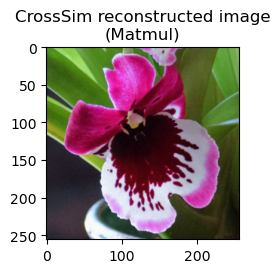

In [20]:
X_recon = np.zeros(X_flower.shape, dtype=np.complex128)

for ch in range(Nch):
    y_imed = xbar_dft @ X_flower[:,:,ch]    # Matmul w/ MVM (forward 1)
    Y_ch = y_imed @ xbar_dft     # Matmul w/ VMM (forward 2)
    x_imed = xbar_idft @ Y_ch     # Matmul w/ MVM (inverse 1)
    X_recon[:,:,ch] = x_imed @ xbar_idft     # Matmul w/ VMM (inverse 2)

# Normalize
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.set_title("CrossSim reconstructed image\n(Matmul)")
ax.imshow(X_recon)
plt.show()

In many cases, the in-memory computing array cannot be used bi-directionally, i.e. cannot support both MVM and VMM. In this case, we need to program four separate arrays: the matrix and its transpose, for the DFT and the inverse DFT. To properly simulate this case, we should create four AnalogCores and simulate MVMs only:

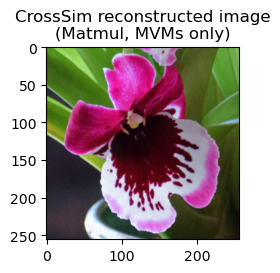

In [21]:
# Create Analog Cores
xbar_dft = AnalogCore(W_dft, params=params_dft)
xbar_dft_T = AnalogCore(W_dft.T, params=params_dft)
xbar_idft = AnalogCore(W_idft, params=params_idft)
xbar_idft_T = AnalogCore(W_idft.T, params=params_idft)

X_recon = np.zeros(X_flower.shape, dtype=np.complex128)

for ch in range(Nch):
    y_imed = xbar_dft @ X_flower[:,:,ch]
    Y_ch = xbar_dft_T @ y_imed
    x_imed = xbar_idft @ Y_ch
    X_recon[:,:,ch] = xbar_idft_T @ x_imed

# Normalize
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.set_title("CrossSim reconstructed image\n(Matmul, MVMs only)")
ax.imshow(X_recon)
plt.show()

### 1.3. Example: Solving linear systems

Let's do one more example showing how we can integrate CrossSim with existing numerical APIs.

Iterative linear solvers are a potentially interesting application for analog MVM because the matrix is fixed for many iterations and the primary computation is MVM. In this example we're going to solve a system of linear equations, $\mathbf{A}x = b$ using conjugate gradient (CG).

For CG to converge, our matrix needs to be symmetric positive definite so we'll first make a random matrix with those properties and a matching random input vector.

In [22]:
size = 10
A = np.random.randn(size, size)

# Make the matrix symmetric
A = A @ A.T

# Make the matrix diagonally dominant 
for i in range(size):
    A[i,i] = np.sum(np.abs(A[i])) - A[i,i]

b = np.random.rand(size)

print("cond(A) = ", np.linalg.cond(A))

cond(A) =  5.24212255898053


Based on the condition number we can see that this is a relatively simple problem to solve, so we can skip a preconditioner, although for most problems of interest you will probably want a preconditioner.

We can see that this matrix converges with CG by comparing the output to a direct solve. We do need to change the tolerance for our comparison to match the convergence threshold we're using in CG. We'll also use the info return value from the cg() function to determine if the algorithm converged. A non-zero return indicates convergence failed.

In [23]:
# Direct solve
x_ideal = np.linalg.solve(A, b)

# Conjugate gradient using scipy
x_cg, info = scipy.sparse.linalg.cg(A, b)

if not info:
    assert(np.allclose(x_ideal, x_cg, atol=1e-05))
    print("---CG converged successfully---")
else:
    print("---CG failed to converge---")

---CG converged successfully---


Now we can do the same thing with CrossSim. CrossSim's AnalogCore was structured to implement the Scipy LinearOperator API so MVM can be invoked using the AnalogCore.matvec() function. Since Scipy's cg() function is based on this API we can simply drop in AnalogCore for this function.

We need to make one change to the default CrossSim parameters to use the Scipy cg() function. In an iterative linear solver the input vector can change over several orders of magnitude as the algorithm converges. CrossSim provides two modes for scaling weights and inputs: explicitly set min and max values, or percentile scaling where CrossSim will set the min and max based on a percentile of the value range. For matrices, CrossSim defaults to percentile scaling, but for inputs CrossSim defaults to explicit min and max values. Since the input vector min and max will be changing inside the cg() function between iterations we will use percentile scaling rather than an explicit min and max. Note that this does imply digital rescaling between each iteration.

In [24]:
params = set_params()
params.core.mapping.inputs.mvm.min = None
params.core.mapping.inputs.mvm.max = None
params.core.mapping.inputs.mvm.percentile = 1.0

# Create and program AnalogCore
xbar = AnalogCore(A, params=params)

# Pass AnalogCore into conjugate gradient method
x_xbar, info_xbar = scipy.sparse.linalg.cg(xbar, b)

if not info_xbar:
    assert(np.allclose(x_cg, x_xbar))
    print("---CrossSim converged to the same result as ideal CG!---")
else:
    print("---CG failed to converge---")

---CrossSim converged to the same result as ideal CG!---
